In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime



In [2]:
conn = sqlite3.connect('papcorns.sqlite')

In [3]:
#Import Users Table into dataframe

users_df = pd.read_sql_query("SELECT*FROM users;",conn)

In [4]:
#Import Users Event Table into dataframe

events_df = pd.read_sql_query("SELECT*FROM user_events;",conn)

In [5]:
#Check columns and records's amount of Users df

users_df.shape

(1002, 5)

In [6]:
#Check columns and records's amount of Users Event df

events_df.shape

(3486, 5)

In [7]:
#lets remove id in events_df. user_id is reference od id in users_df


events_df = events_df.drop(columns='id',axis = 1)

In [8]:
#There is a problem with created column cronologically. There are some date at the future so those values should be removed from dataset

events_df['created_at'] = pd.to_datetime(events_df['created_at'])


In [9]:
row1 = events_df.shape[0]

In [10]:
events_df.drop(events_df[events_df['created_at']>pd.Timestamp.now()].index,axis = 0,inplace=True)

In [11]:
row2 = events_df.shape[0]

In [12]:
print(row1-row2,' rows are dropped from events_df')

168  rows are dropped from events_df


In [13]:
#Modify subscription_renewed depending on counts of done based on user_id
#There are multiple time for renewd that s aproblem convert our dataframe into pivot table
#Thats why we redesign oour subscription_renewed rows based on user_id

events_df['event_name'] = events_df['event_name'].astype('category')


renewed_counts = events_df[events_df['event_name'] == 'subscription_renewed'].groupby('user_id').size().reset_index(name='subscription_renewed')


In [37]:
#Create new dataframe with count of subscription_renewed  

x_df = events_df[['user_id']].drop_duplicates()  
df_subscription_renewed = x_df.merge(renewed_counts, on='user_id', how='left').fillna(0).astype('int')

In [38]:
df_subscription_renewed

,user_id,subscription_renewed
0,1,0
1,2,3
2,3,3
3,4,0
4,5,0
...,...,...
997,998,0
998,999,1
999,1000,0
1000,1001,0


In [39]:
filtered_df = events_df[events_df['event_name']!='subscription_renewed']

In [40]:
#removed rows including 'subscription_renewed'


filtered_df['event_name'].value_counts()

app_install               1002
trial_started              682
subscription_started       480
subscription_cancelled     307
trial_cancelled            201
subscription_renewed         0
Name: event_name, dtype: int64

In [41]:
#Convert dataframe pivot table indexed by user_id, 
#create columns with event name without subscription renewed

df_pivot_no_renewed = filtered_df.pivot_table(index='user_id', columns='event_name', values='created_at')

In [42]:
df_pivot_no_renewed = df_pivot_no_renewed.reset_index()

In [43]:
#Dataframe without subscription_renewed

df_pivot_no_renewed

event_name,user_id,app_install,subscription_cancelled,subscription_started,trial_cancelled,trial_started
0,1,2024-05-07,NaT,NaT,2024-05-24,2024-05-12
1,2,2024-10-12,2025-02-12,2024-10-20,NaT,2024-10-13
2,3,2024-10-15,2025-01-20,2024-10-21,NaT,2024-10-19
3,4,2024-08-28,NaT,NaT,2024-09-06,2024-08-31
4,5,2024-04-03,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...
997,998,2025-02-01,NaT,NaT,NaT,NaT
998,999,2024-12-24,NaT,2025-01-03,NaT,2024-12-29
999,1000,2025-02-13,NaT,NaT,2025-02-25,2025-02-15
1000,1001,2025-02-25,NaT,2025-02-25,NaT,2025-02-25


In [44]:
#Finally merge pivot table with  subscription_renewed counts 

df_final = df_pivot_no_renewed.merge(df_subscription_renewed, on='user_id', how='inner')

In [45]:
df_final

,user_id,app_install,subscription_cancelled,subscription_started,trial_cancelled,trial_started,subscription_renewed
0,1,2024-05-07,NaT,NaT,2024-05-24,2024-05-12,0
1,2,2024-10-12,2025-02-12,2024-10-20,NaT,2024-10-13,3
2,3,2024-10-15,2025-01-20,2024-10-21,NaT,2024-10-19,3
3,4,2024-08-28,NaT,NaT,2024-09-06,2024-08-31,0
4,5,2024-04-03,NaT,NaT,NaT,NaT,0
...,...,...,...,...,...,...,...
997,998,2025-02-01,NaT,NaT,NaT,NaT,0
998,999,2024-12-24,NaT,2025-01-03,NaT,2024-12-29,1
999,1000,2025-02-13,NaT,NaT,2025-02-25,2025-02-15,0
1000,1001,2025-02-25,NaT,2025-02-25,NaT,2025-02-25,0


In [46]:
#Widen dataframe with column users table by merging based on user_id
#.drop(columns = ['key_0']) disallow create duplicated columns during merging

df_final =  pd.merge(df_final,users_df[['attribution_source','country','name']]\
                     , left_on=df_final['user_id'],right_on =users_df['id'], how='inner').drop(columns = ['key_0'])

In [47]:
#Let create it  properly 

df_final['amount_usd'] = df_final['user_id'].map(events_df.groupby('user_id')['amount_usd'].sum())

In [48]:
df_final.head()

,user_id,app_install,subscription_cancelled,subscription_started,trial_cancelled,trial_started,subscription_renewed,attribution_source,country,name,amount_usd
0,1,2024-05-07,NaT,NaT,2024-05-24,2024-05-12,0,instagram,US,Eve Brown,0.00
1,2,2024-10-12,2025-02-12,2024-10-20,NaT,2024-10-13,3,instagram,NL,Frank Moore,35.96
2,3,2024-10-15,2025-01-20,2024-10-21,NaT,2024-10-19,3,tiktok,TR,Ivy Anderson,19.96
3,4,2024-08-28,NaT,NaT,2024-09-06,2024-08-31,0,tiktok,TR,Alice Brown,0.00
4,5,2024-04-03,NaT,NaT,NaT,NaT,0,organic,NL,Bob Moore,0.00


## APP_INSTALL DURATION

In [49]:
(df_final['trial_started']-df_final['app_install'])\
    .dt.days.value_counts(dropna =False)\
    .sort_index()

0.0      1
1.0    113
2.0    121
3.0    113
4.0    118
5.0    105
6.0    111
NaN    320
dtype: int64

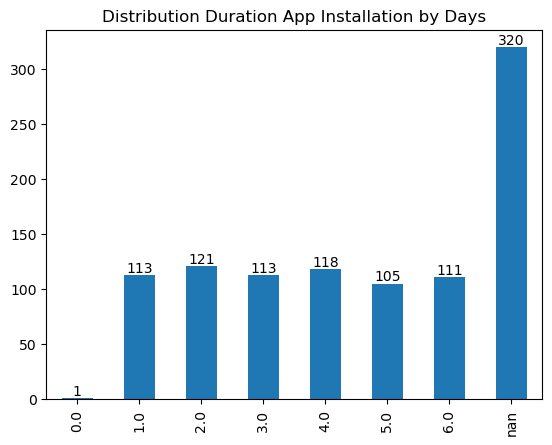

In [50]:
#Distribution of app_install-TO-trial
#Trials have been started in early 6 days otherwise Never

ax = (df_final['trial_started']-df_final['app_install'])\
    .dt.days.value_counts(dropna =False)\
    .sort_index().plot(kind='bar')

ax.bar_label(ax.containers[0])
plt.title('Distribution Duration App Installation by Days')
plt.show()

In [51]:
#Add a new colum of app_install duration
#It seems it is disallowed to use trial after 6 days
#Even though so. I use this method to overcome Null value problem
#If I do no subtract app_install date from now then whole value return Nan
#By this way i can use app_install duration for non-trial as well in my data set
#and normalization and standardization also overcome for huges value of duration of app_install

df_final['Duration_app_install'] = [(df_final.loc[i,'trial_started']-df_final.loc[i,'app_install']).days\
                                             if pd.notna(df_final.loc[i,'trial_started'])\
                                             else (pd.Timestamp.now()-df_final.loc[i,'app_install']).days
                                             for i in df_final.index ]

## TRIAL DURATION

In [52]:
#Create new column Trial Duration
#Trial duration is calculated depending on 3 situation

#1- never trial return 0
#2 ever trial but not subcripted trial_cancelled -trial_started
#3 when go into subscrition started then subscription_start-trial_started


df_final['Duration_trial'] = np.where(
    df_final['trial_started'].isna(), 
    0,  # If no trial started, set duration to 0
    np.where(
        df_final['trial_cancelled'].notna(), 
        (df_final['trial_cancelled'] - df_final['trial_started']).dt.days, 
        np.where(
            df_final['subscription_started'].notna(), 
            (df_final['subscription_started'] - df_final['trial_started']).dt.days, 
            0  # If trial started but no cancellation or subscription, default to 0
        )
    )
).astype('int')

In [53]:
#Here 0 store non-trial as well

df_final['Duration_trial'].value_counts(dropna=False).sort_index()

0     322
1      52
2      44
3      52
4      54
5      64
6      45
7      68
8      41
9      56
10     49
11     58
12     42
13     55
Name: Duration_trial, dtype: int64

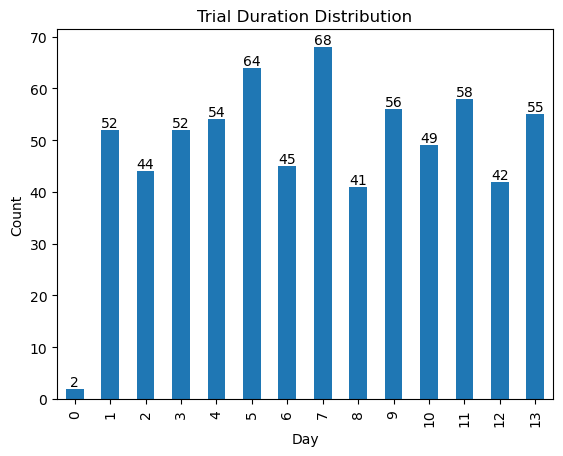

In [54]:
#Trial Duration Distribution by Day
#we filter only the trial user df_final[pd.notna(df_final['trial_started'])]['Duration_trial']

#Note !...  :  Trial Duration have been taken in former 2 weeks atmost

ax1 = df_final[pd.notna(df_final['trial_started'])]['Duration_trial'].value_counts(dropna=False)\
.sort_index().plot(kind = 'bar')
ax1.bar_label(ax1.containers[0])
plt.title('Trial Duration Distribution')
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()

In [82]:
#The rate start trial to app_install

print('%',round((df_final['trial_started']-df_final['app_install'])\
    .dt.days.value_counts(dropna =True)\
    .sort_index().sum()/ (df_final['trial_started']-df_final['app_install'])\
    .dt.days.value_counts(dropna =False)\
    .sort_index().sum()*100,2),"of Total start trial")

% 68.06 of Total start trial


## Subscription Duration

In [56]:
#Subscription duration is calculated here according to now for ongoing subscription
#This is not make sense when store this data in permanent storage

df_final['Duration_subscription'] = np.where(
    df_final['subscription_started'].isna(), 
    0,
    np.where(
        df_final['subscription_cancelled'].notna(), 
        (df_final['subscription_cancelled'] - df_final['subscription_started']).dt.days, 
        (pd.Timestamp.now() - df_final['subscription_started']).dt.days
    )
).astype('int')   

In [69]:
df_final['Duration_subscription'].value_counts().sort_index()

0      523
2        1
4        1
5        1
6        2
      ... 
399      2
403      1
405      1
412      1
413      1
Name: Duration_subscription, Length: 186, dtype: int64

1002

In [103]:
print('%',round((df_final[df_final['trial_started'].notna()]\
                 .shape[0]/df_final[df_final['app_install'].notna()]\
                 .shape[0])*100,2),"of app_installer start Trial")

% 68.06 of app_installer start Trial


In [100]:
print('%',round((df_final[df_final['subscription_started'].notna()]\
                 .shape[0]/df_final[df_final['trial_started'].notna()]\
                 .shape[0])*100,2),"of who used Trial start subscription")

% 70.38 of who used Trial start subscription


In [88]:
print('%',round((df_final[df_final['subscription_started'].notna()]\
                 .shape[0]/df_final.shape[0])*100,2),"of app_installer start subscription")

% 47.9 of app_installer start subscription


## Further Feature Engineering 

In [105]:
#Create a column define the record has ever started subscrition


df_final['Ever_Subscripted'] = pd.Series([0 if pd.isnull(i) else 1 \
                                          for i in df_final['subscription_started']])

In [106]:
#At some case subscription has started less than 1 month.
#This column solve problem if sebscription_renewed has 0

#df_final[(df_final['trial_cancelled'].notnull())&(df_final['subscription_started'].notnull())]
#Bu kod trial cancel olmadan subscription started olan var mi ona bakiyor. Boyle bir durum yok

#df_final[(df_final['trial_started'].isnull())&(df_final['subscription_started'].notnull())]
#Bu kod ise trial olmadan dogrudan subscript var mi onu cek ediyor. Boyle bir durum da yok

#Bu check kodlari is_still sutunu olusturmak icin lazim

df_final['Still_Subscripted'] = pd.Series([1 if pd.notnull(i)==True and pd.isnull(k)==True\
                                           else 0 for i,k in\
                                           zip(df_final['subscription_started'],df_final['subscription_cancelled'])
  ])

In [108]:
df_final

,user_id,app_install,subscription_cancelled,subscription_started,trial_cancelled,trial_started,subscription_renewed,attribution_source,country,name,amount_usd,Duration_app_install,Duration_trial,Duration_subscription,Ever_Subscripted,Still_Subscripted
0,1,2024-05-07,NaT,NaT,2024-05-24,2024-05-12,0,instagram,US,Eve Brown,0.00,5,12,0,0,0
1,2,2024-10-12,2025-02-12,2024-10-20,NaT,2024-10-13,3,instagram,NL,Frank Moore,35.96,1,7,115,1,0
2,3,2024-10-15,2025-01-20,2024-10-21,NaT,2024-10-19,3,tiktok,TR,Ivy Anderson,19.96,4,2,91,1,0
3,4,2024-08-28,NaT,NaT,2024-09-06,2024-08-31,0,tiktok,TR,Alice Brown,0.00,3,6,0,0,0
4,5,2024-04-03,NaT,NaT,NaT,NaT,0,organic,NL,Bob Moore,0.00,330,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,998,2025-02-01,NaT,NaT,NaT,NaT,0,instagram,TR,Bob Davis,0.00,26,0,0,0,0
998,999,2024-12-24,NaT,2025-01-03,NaT,2024-12-29,1,organic,NL,Charlie Davis,17.98,5,5,55,1,1
999,1000,2025-02-13,NaT,NaT,2025-02-25,2025-02-15,0,organic,NL,Jack Anderson,0.00,2,10,0,0,0
1000,1001,2025-02-25,NaT,2025-02-25,NaT,2025-02-25,0,instagram,US,Bruce Wayne,9.99,0,0,2,1,1
